## Variational Auto-Encoder

This script trains a simple VAE on a set of celebrity faces (The popular [CelebA dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)).

In [ ]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [ ]:
%pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from fastai.vision.all import *
from fastai.callback.hook import *
from IPython.display import display, clear_output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path = untar_data('https://algorithmicgaze.s3.amazonaws.com/projects/2024-onnx-experiments/datasets/celeb_faces_50k.zip')
print(len(path.ls()))

50001


In [ ]:
# There are no labels, so the target label is just the input image itself
def get_x(r): return r  # Returns the image file path
def get_y(r): return r # Returns the same image file path for the target

dblock = DataBlock(blocks=(ImageBlock, ImageBlock),  # Define input and target blocks as images
                   get_items=get_image_files,        # Function to get image files
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split data into training and validation sets
                   get_x=get_x,  # Function to get the input images
                   get_y=get_y,  # Function to get the target images (same as input)
                   item_tfms=Resize(256),  # Resize images to 256x256
                   batch_tfms=aug_transforms(size=256))
dls = dblock.dataloaders(path, bs=64)  # Create dataloaders from the data block

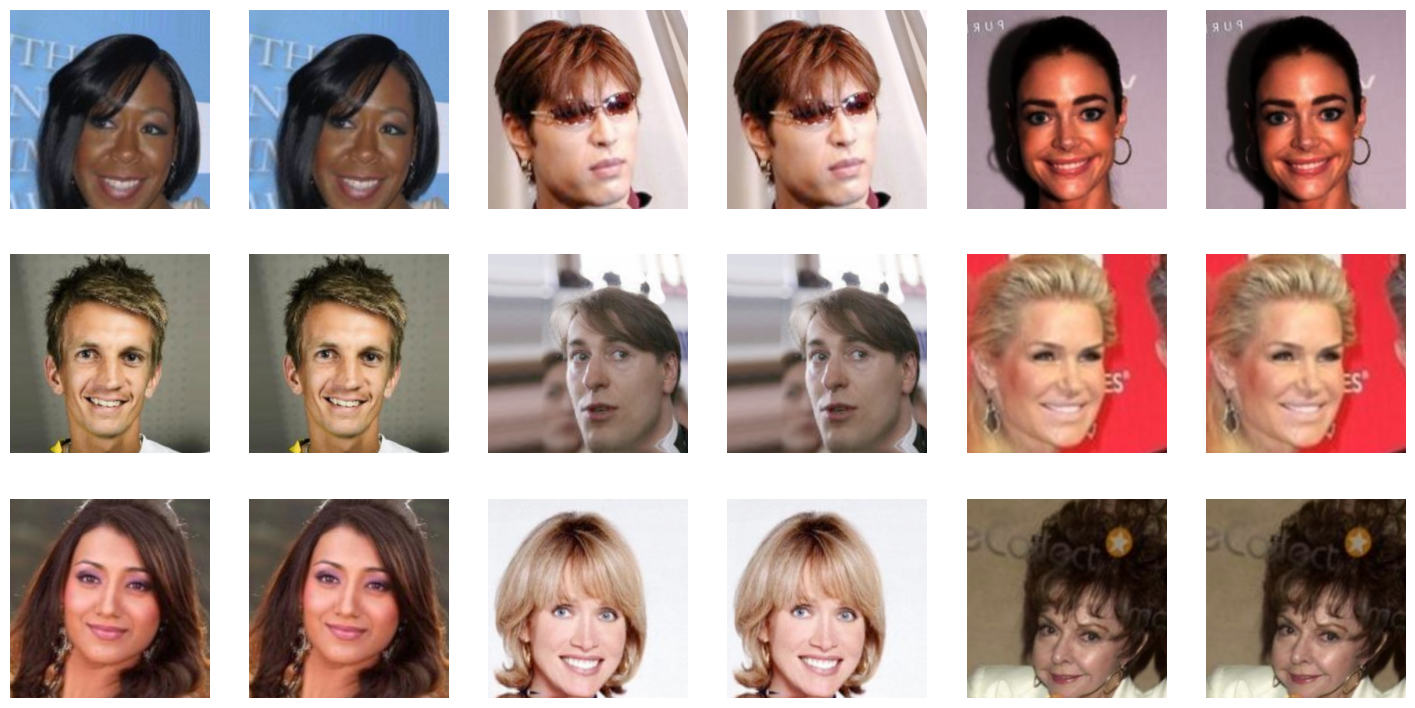

In [ ]:
dls.show_batch()

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder Layers
        # Convolutional layers to downsample the image
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1) # Output: 128x128
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1) # Output: 64x64
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) # Output: 32x32
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) # Output: 16x16

        # Fully connected layers to produce the mean and log variance
        self.fc1 = nn.Linear(in_features=256*16*16, out_features=1024)
        self.fc_mu = nn.Linear(in_features=1024, out_features=256)
        self.fc_log_var = nn.Linear(in_features=1024, out_features=256)

        # Decoder Layers
        # Fully connected layers to upscale the sample
        self.fc2 = nn.Linear(in_features=256, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=256*16*16)

        # Transposed convolutional layers to upsample the image back to original size
        self.deconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1) # Output: 32x32
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1) # Output: 64x64
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1) # Output: 128x128
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1) # Output: 256x256

    def encode(self, x):
        # Forward pass through encoder layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        return self.fc_mu(x), self.fc_log_var(x)

    def reparameterize(self, mu, log_var):
        # Reparameterization trick to sample from latent space
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std

    def decode(self, z):
        # Forward pass through decoder layers
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, 16, 16)  # Reshape to match the input shape of the first transposed conv layer
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        return torch.sigmoid(self.deconv4(z))  # Using sigmoid for the final layer to output values between 0 and 1

    def forward(self, x):
        # Forward pass through the entire VAE
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

In [ ]:
# Define the loss function
def vae_loss(outputs, targets):
    reconstructed, mu, log_var = outputs
    #print(f"reconstructed {reconstructed.shape} targets {targets.shape}")
    # Calculate reconstruction loss and KL divergence
    reconstruction_loss = F.mse_loss(reconstructed, targets, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_div

In [ ]:
def show_images(images, nmax=64):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.axis('off')
    plt.show()

def visualize_results():
  # Visualize original/reconstructed images

  # Load a batch of images
  x, _ = dls.one_batch()
  x = x.to(device)  # Move to the same device as your model

  # VAE forward pass
  with torch.no_grad():
    reconstructed, _, _ = vae_model(x)

  # Convert to numpy for plotting
  x = x.cpu().numpy()
  reconstructed = reconstructed.cpu().numpy()

  # Plotting
  show_images(x[:5])  # Show original images
  show_images(reconstructed[:5])  # Show reconstructed images


In [ ]:
class VAEVisualizeCallback(Callback):
    def __init__(self, n_images=5):
        self.n_images = n_images  # Number of images to display

    def after_epoch(self):
      clear_output(wait=True)
      visualize_results()

In [ ]:
# Instantiate the model
vae_model = VAE()  # Replace with your model class if different

# Create a fast.ai Learner
learn = Learner(dls, vae_model, loss_func=vae_loss, cbs=VAEVisualizeCallback())

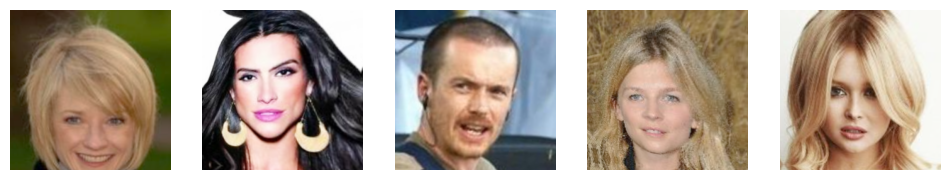

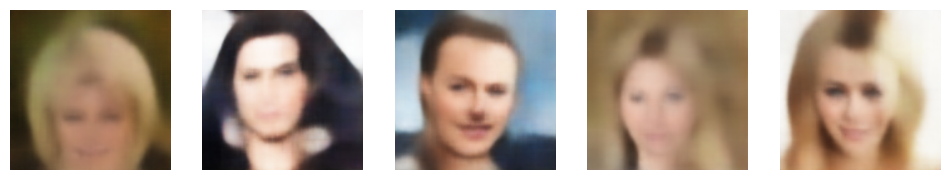

epoch,train_loss,valid_loss,time
0,120050.687500,122000.000000,00:56
1,127187.812500,130086.593750,00:59
2,128993.875000,127347.890625,00:57


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(10)

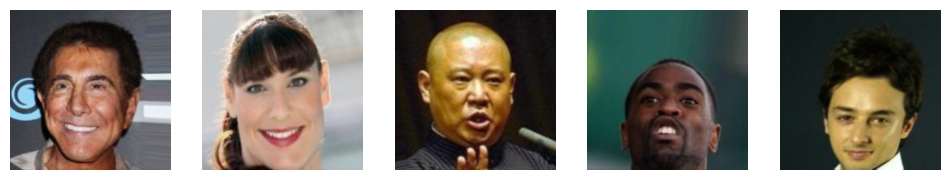

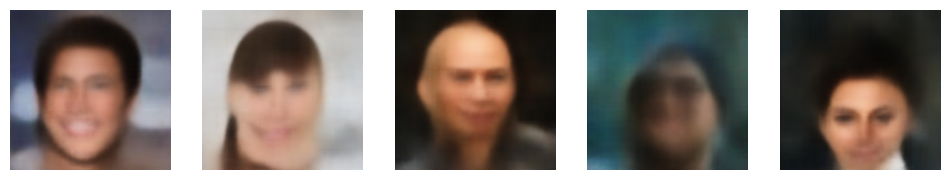

In [ ]:
visualize_results()

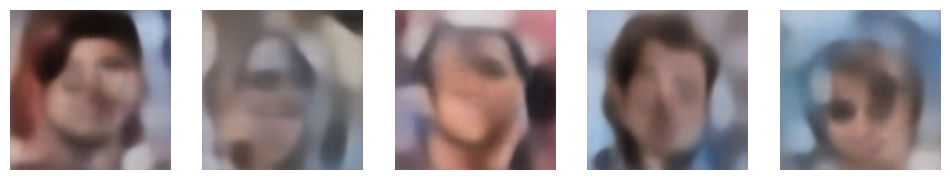

In [ ]:
# Generate random samples

# Define the size of the latent space
latent_dim = 256  # Adjust based on your model's latent dimension

# Sample random vectors from the standard normal distribution
random_latent_vectors = torch.randn(5, latent_dim).to(device)  # Generate 5 random samples

# Decode the random latent vectors
with torch.no_grad():
    random_samples = vae_model.decode(random_latent_vectors).cpu().numpy()

# Plot the random samples
show_images(random_samples)


In [ ]:
# Export the model
learn.export("celeb_faces_vae.pkl")
torch.save(learn.model.state_dict(), "celeb_faces_vae.pth")

VAE(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc_mu): Linear(in_features=1024, out_features=256, bias=True)
  (fc_log_var): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=65536, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [ ]:
# Export the model to ONNX
# This is just the decoder part of the model, so first let's put that into
# a new module:

class VAEDecoder(nn.Module):
    def __init__(self, vae_model):
        super(VAEDecoder, self).__init__()
        self._vae = vae_model
        self.decode = vae_model.decode  # Use the decode method of the trained VAE

    def forward(self, z):
        #z = z.detach()
        #return self.decode(z)

        z = self._vae.fc2(z).relu()
        z = self._vae.fc3(z).relu()
        z = z.view(z.size(0), 256, 16, 16)
        z = self._vae.deconv1(z).relu()
        z = self._vae.deconv2(z).relu()
        z = self._vae.deconv3(z).relu()
        z = self._vae.deconv4(z).relu()
        return torch.sigmoid(z)

# Now load in the model

vae_model_2 = VAE()
vae_model_2.load_state_dict(torch.load("celeb_faces_vae.pth"))
vae_model_2.eval()
decoder_model = VAEDecoder(vae_model_2)
for param in decoder_model.parameters():
    param.requires_grad = False

dummy_input = torch.randn(1, latent_dim, requires_grad=False)

torch.onnx.export(
    decoder_model,
    dummy_input,
    "celeb_faces_vae_decoder.onnx",
    do_constant_folding=True,
    export_params=True,
    input_names=["latent_vector_1_256"],
    output_names=["output_image"],
    opset_version=11
)

In [ ]:
# Save model to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
drive_path = "/content/drive/MyDrive/2024-onnx-experiments/"
model_file = 'celeb_faces_vae_decoder.onnx'
os.makedirs(drive_path, exist_ok=True)
shutil.copy(model_file, os.path.join(drive_path, model_file))

'/content/drive/MyDrive/2024-onnx-experiments/celeb_faces_vae_decoder.onnx'

In [ ]:
import onnxruntime as rt
sess = rt.InferenceSession('celeb_faces_vae_decoder.onnx')
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
input_dims = sess.get_inputs()[0].shape

In [ ]:
latent = np.random.rand(1, 256).astype(np.float32)
#latent = np.random.exponential(2.0, (1, 256)).astype(np.float32)
#latent = np.random.poisson(3.0, (1, latent_dim)).astype(np.float32)
result = sess.run([output_name], {input_name: latent})[0]

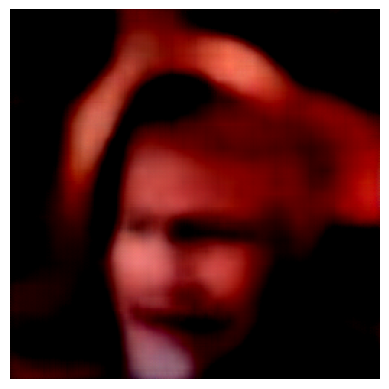

In [ ]:
img = result.squeeze(0)
img = np.transpose(img, (1, 2, 0))
img = (img - img.min()) / (img.max() - img.min())
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.axis('off')
plt.show()

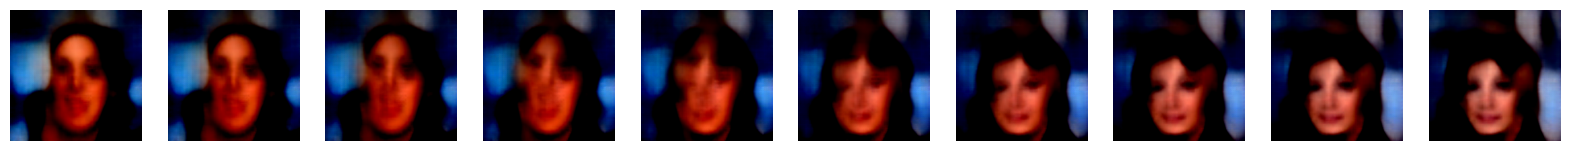

In [ ]:
# Latent walk
latent_dim = 256
latent1 = np.random.randn(1, latent_dim).astype(np.float32)
latent2 = np.random.randn(1, latent_dim).astype(np.float32)

def interpolate(start, end, steps):
    interpolation = np.zeros((steps, start.size)).astype(np.float32)
    for i in range(steps):
        alpha = i / (steps - 1)
        interpolation[i] = alpha * end + (1 - alpha) * start
    return interpolation


steps = 10
interpolated_latents = interpolate(latent1, latent2, steps)

fig, axes = plt.subplots(1, steps, figsize=(20, 2))
for i, latent in enumerate(interpolated_latents):
    # Generate image
    result = sess.run([output_name], {input_name: latent.reshape(1, -1)})[0]
    img = result.squeeze(0)
    img = np.transpose(img, (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    img = np.clip(img, 0, 1)

    # Plot image
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

